27.02.2018 -- Email from Steve: 

also be interesting:

    -  calculate the total snow water path (SWP, integrated SWC throughout the depth of the cloud)
$\rightarrow$ could then compare the model SWP with the retrieval SWP to see if we are in the right ball park
i.e. see if the models are producing the right amount of snow to the first order.  This also may give us further insight into how to deal with the units.   



In [1]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
import netCDF4
import fill_values as fv
import datetime
import calc_date as cd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import save_fig as SF
import createFolder as cF
import plot_vertical as pvert

from scipy.integrate import simps

In [2]:
year = '2016'
month = '12'
#day = '25'
t = ['17','18','19','20', '21', '22', '23', '24', '25', '26', '27']
tid = '00'
station = 'Haukeliseter'

figdir = '../../Figures/MEPS/snowfall_amount'
cF.createFolder('%s/' %(figdir))
form = 'png'


level = 'sfc'
nc_dir_sfc = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
level = 'ml'
nc_dir_ml = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)

In [3]:
figdir = '../../Figures/MEPS/SWP'
cF.createFolder('%s/' %(figdir))
form = 'png'

In [4]:
var_name_ml = 'snowfall_amount_ml'
SWC_dir = '%s/%s' %(nc_dir_ml,var_name_ml)

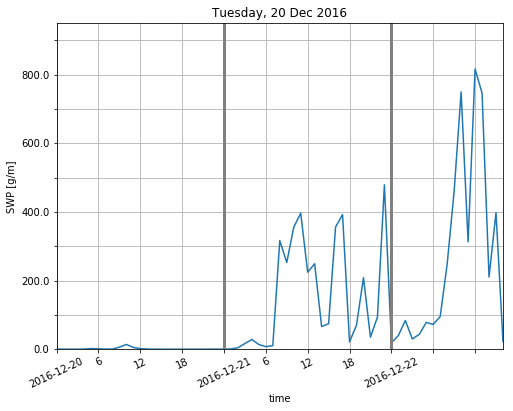

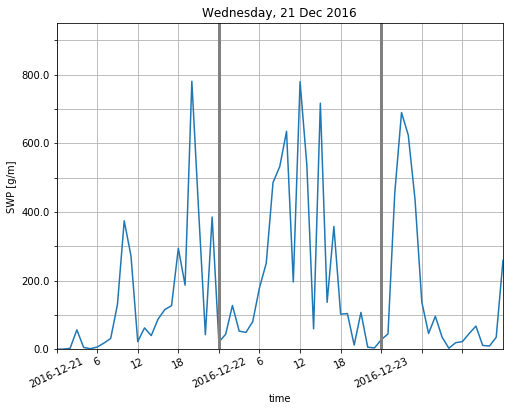

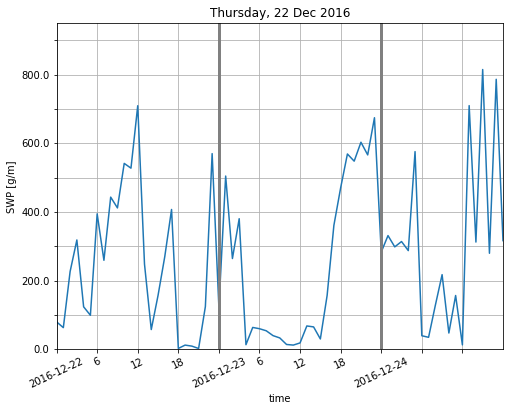

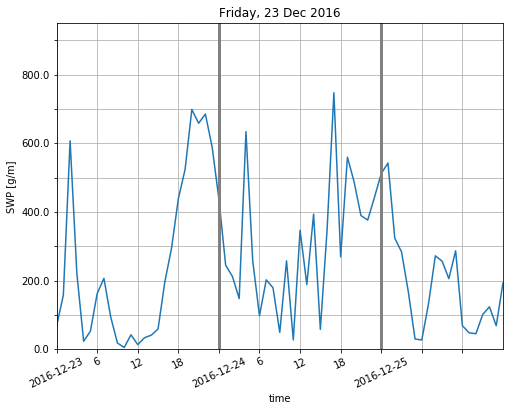

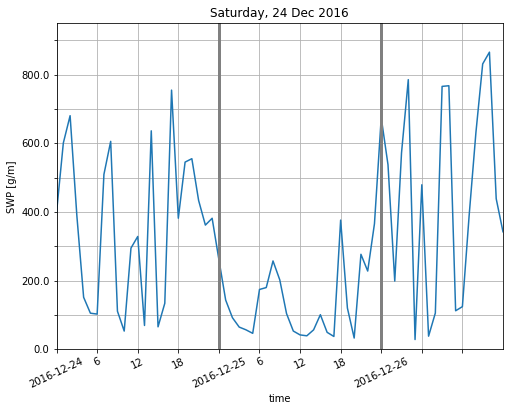

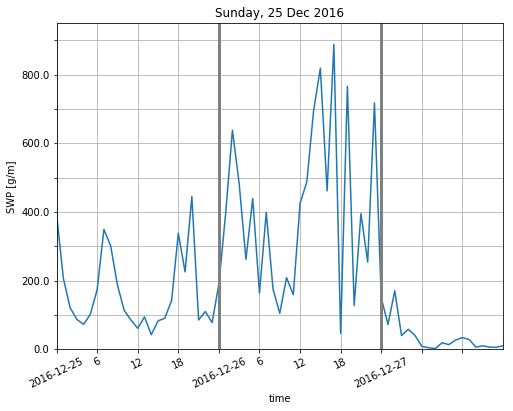

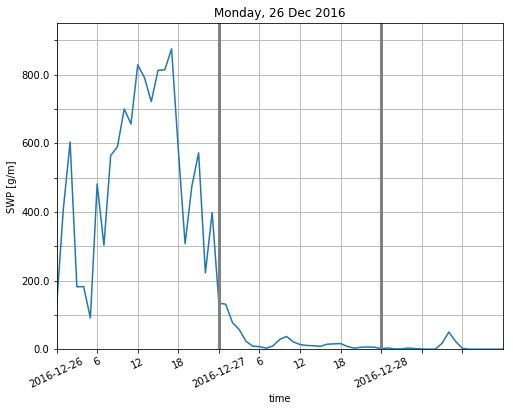

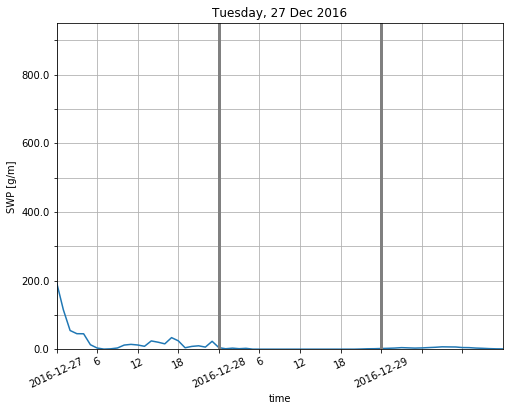

In [7]:
for day in t:

    SWC_file       = dict()
    fn_ml          = dict()
    time_ml        = dict()
    snow_amount_ml = dict()
    thickness_ml   = dict()
    time           = dict()
    height_ml      = dict()
    height         = dict()
#for day in t:


    for ens_memb in range(0,10):
        SWC_file[ens_memb] = '%s/%s%s%s_%s_%s.nc' %(SWC_dir,year,month,day,tid,ens_memb)
        fn_ml[ens_memb] = netCDF4.Dataset(SWC_file[ens_memb])
# Read in time to know initialisation time (plotting)    
        time_ml[ens_memb] = fn_ml[ens_memb].variables['time']
        time_ml[ens_memb] = fv.fill_nan(time_ml[ens_memb][:])
        

        ini_day = datetime.datetime.utcfromtimestamp(time_ml[0][0]).day   # day of initialisation
        hh = datetime.datetime.utcfromtimestamp(time_ml[0][0]).hour       # first hour of initialisation?
        calday, calmon = cd.get_dayname(year, month, ini_day)
# Read in the variable name which should be plotted  
        snow_amount_ml[ens_memb] = fn_ml[ens_memb].variables[var_name_ml]

# Read in the thickness of a layer
        thickness_ml[ens_memb] = fn_ml[ens_memb].variables['layer_thickness']
# create an array with time of the shape of the variable
        lead_time = np.arange(0,snow_amount_ml[ens_memb].shape[0])
        model_level = np.arange(0,snow_amount_ml[ens_memb].shape[1])
        td,Y = np.meshgrid(lead_time,model_level)

# substitute missing values with nan       
        snow_amount_ml[ens_memb] = fv.fill_nan(snow_amount_ml[ens_memb][:])
        thickness_ml[ens_memb] = fv.fill_nan(thickness_ml[ens_memb][:])
    
    
# layer thickness to calculate height
        thickness_ml[ens_memb]      = fn_T_z_p[ens_memb].variables['layer_thickness']
        thickness_ml[ens_memb]      = fv.fill_nan(thickness_ml[ens_memb][:])
    
        thickness = thickness_ml[ens_memb]
        h_above = []
        h_above.append(np.zeros(thickness[:,:].shape[0]))
        th_arr = np.nansum([np.asarray(h_above)[:,0], thickness[:,0]], axis = 0)
        h_above.append(th_arr)
        for i in range(2,thickness[:,:].shape[1]):
            th_arr = np.nansum([h_above[i-1], thickness[:,i-1]], axis = 0)
            h_above.append(th_arr)
        height_ml[ens_memb] = np.transpose(h_above)




        
        
# get only valuable values not nan    
        time_ml[ens_memb] = time_ml[ens_memb][~np.isnan(time_ml[ens_memb])]
        time[ens_memb] =(td[:,~np.isnan(snow_amount_ml[ens_memb]).any(axis=1)])
        height[ens_memb]        = (height_ml[ens_memb][~np.isnan(snow_amount_ml[ens_memb]).any(axis=1),:])
        thickness_ml[ens_memb] = (thickness_ml[ens_memb][~np.isnan(snow_amount_ml[ens_memb]).any(axis=1),:])   
        snow_amount_ml[ens_memb] = (snow_amount_ml[ens_memb][~np.isnan(snow_amount_ml[ens_memb]).any(axis=1)])
# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
        snow_amount_ml[ens_memb] = (snow_amount_ml[ens_memb]*1000.)
    

        SWP = []
        for i in range(0,snow_amount_ml[0][:,:].shape[0]):
            SWP.append(simps(y = snow_amount_ml[0][i,np.where(height[0][i,:] < 3000)], x = height[0][i,np.where(height[0][i,:] < 3000)]))

        
        
    fig_name = '%s%s%s.png' %(year,month,ini_day)
    plt.figure(figsize = (8,6))
    ax0 = plt.subplot(111)

    ax0.plot(time[0][0,:], SWP)
#plt.xlim([time_ml[0].min(),time_ml[0].max()])
# set the limits of the plot to the limits of the data
    ax0.axis([time[0][0,:].min(), time[0][0,:].max(), 0, 950.])

# Vertical line to show end of day
    ax0.axvline(24,color = 'grey', linewidth = 3)
    ax0.axvline(48,color = 'grey', linewidth = 3)

# label ticks for plotting
    dates = pvert.dates_plt(time_ml[0])
    yl = [0., '' , 200.0, '' , 400., '' , 600., '', 800.,'',900.]

# labels
    ax0.set_xticks(np.arange(0,time[0][0,:].max(),6))

    ax0.tick_params(axis='both',which='both',bottom='on',top='off',labelbottom='on')#,labelsize = 20)
    ax0.set_xticklabels(dates, rotation = 25)#, fontsize = 20)
    ax0.set_xlabel('time')#, fontsize = 22)

    ax0.set_ylabel('SWP [g/m]')#, fontsize = 22)
    ax0.set_yticks(np.arange(0,950.,100))
    ax0.set_yticklabels(yl)#, fontsize = 20)

    plt.title('%s, %s %s %s' %(calday,ini_day,calmon,year))

    plt.tight_layout

    plt.grid()
    
    SF.save_figure_landscape(figdir, fig_name, form)
    plt.show()
    plt.close()
    
    for ens_memb in range(0,10):
        fn_ml[ens_memb].close()